In [ ]:
%%time

# Generiche
import random
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np
import os
import glob
import cv2

# Keras
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Flatten, Convolution2D, MaxPooling2D, Dropout, Activation, AveragePooling2D
from keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers 
import keras
from keras.applications import mobilenet_v2
from keras import layers

# Sklearn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, Normalizer, StandardScaler

np.random.seed(1234)
tf.random.set_seed(1234)

CPU times: user 1.54 s, sys: 244 ms, total: 1.79 s
Wall time: 1.69 s


In [ ]:
%%time

!unzip "/content/drive/MyDrive/Colab Notebooks/PROGETTO MUSICA DSIM/DATASET/MEL_IMAGES_DATASET.zip" -d "/content"

In [ ]:
%%time

music_train = []
music_label = []
for dir_path in glob.glob("/content/Train/*"):
    img_label = dir_path.split("/")[-1]
    for image_path in glob.glob(os.path.join(dir_path,"*.jpg")):
        image = cv2.imread(image_path,cv2.IMREAD_COLOR)
        image = cv2.resize(image, (224,224))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        music_train.append(image)
        music_label.append(img_label)
music_train = np.array(music_train)
music_label = np.array(music_label)

CPU times: user 984 ms, sys: 148 ms, total: 1.13 s
Wall time: 1.13 s


In [ ]:
%%time

label_to_id = {v:k for k,v in enumerate(np.unique(music_label)) }
id_to_label = {v:k for k,v in label_to_id.items()}

CPU times: user 889 µs, sys: 0 ns, total: 889 µs
Wall time: 662 µs


In [ ]:
id_to_label

{0: 'Blues',
 1: 'Classical',
 2: 'Country',
 3: 'Disco',
 4: 'Hiphop',
 5: 'Jazz',
 6: 'Metal',
 7: 'Pop',
 8: 'Reggae',
 9: 'Rock'}

In [ ]:
%%time

music_label_id = np.array([label_to_id[i] for i in music_label])

CPU times: user 700 µs, sys: 0 ns, total: 700 µs
Wall time: 708 µs


In [ ]:
%%time

X_train, X_test, y_train, y_test = train_test_split(music_train, music_label_id, test_size=0.1, random_state=101)

CPU times: user 18.1 ms, sys: 28.7 ms, total: 46.8 ms
Wall time: 50.7 ms


In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((899, 224, 224, 3), (899,), (100, 224, 224, 3), (100,))

In [ ]:
X_train = X_train/255
X_test = X_test/255

In [ ]:
X_train.shape

(899, 224, 224, 3)

In [ ]:
y_cat = to_categorical(y_train)
y_cat_tes = to_categorical(y_test)

In [ ]:
base_net = mobilenet_v2.MobileNetV2(input_shape = (224,224,3), include_top= False, weights='imagenet')

In [ ]:
for layer in base_net.layers:
    layer.trainable = False

In [ ]:
# Output of the base model
x = base_net.output
# New intermediate fully-connected layer + ReLU and Flatten layer
x = Flatten()(x)
x = keras.layers.Dense(1024, activation='relu')(x)
# New (final) fully-connected layer + SoftMax activation
pred = keras.layers.Dense(10, activation='softmax')(x)

In [ ]:
net = keras.Model(inputs=base_net.input, outputs=pred)

In [ ]:
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(),
            metrics=['accuracy'])

In [ ]:
history = net.fit(X_train, y_cat, epochs=10, validation_split=0.1)

Epoch 1/10
26/26 [==============================] - 6s 80ms/step - loss: 50.4674 - accuracy: 0.2166 - val_loss: 5.2749 - val_accuracy: 0.4111
Epoch 2/10
26/26 [==============================] - 1s 43ms/step - loss: 2.7878 - accuracy: 0.5661 - val_loss: 2.7453 - val_accuracy: 0.4556
Epoch 3/10
26/26 [==============================] - 1s 43ms/step - loss: 0.6249 - accuracy: 0.8284 - val_loss: 2.3862 - val_accuracy: 0.5111
Epoch 4/10
26/26 [==============================] - 1s 43ms/step - loss: 0.2395 - accuracy: 0.9103 - val_loss: 2.0304 - val_accuracy: 0.5778
Epoch 5/10
26/26 [==============================] - 1s 43ms/step - loss: 0.0917 - accuracy: 0.9772 - val_loss: 2.2066 - val_accuracy: 0.5556
Epoch 6/10
26/26 [==============================] - 1s 43ms/step - loss: 0.0984 - accuracy: 0.9722 - val_loss: 2.1040 - val_accuracy: 0.5333
Epoch 7/10
26/26 [==============================] - 1s 44ms/step - loss: 0.0493 - accuracy: 0.9924 - val_loss: 2.1257 - val_accuracy: 0.6000
Epoch 8/10
2

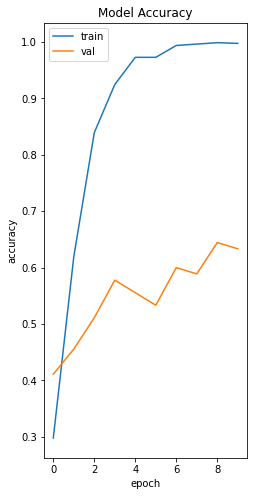

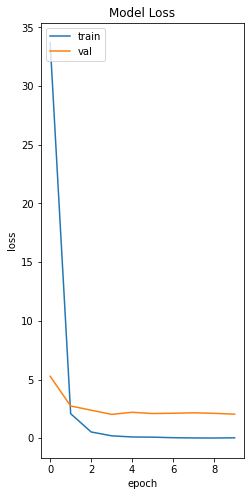

CPU times: user 251 ms, sys: 9.26 ms, total: 260 ms
Wall time: 286 ms


In [ ]:
%%time

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
score_CNN_5 = net.evaluate(X_test, y_cat_tes, verbose=0)
print("Test loss:", score_CNN_5[0])
print("Test accuracy:", score_CNN_5[1])

Test loss: 1.4285399913787842
Test accuracy: 0.6899999976158142


In [ ]:
predictions = net.predict(X_test)

In [ ]:
y_true = np.argmax(y_cat_tes, axis=1)

In [ ]:
y_pred = np.argmax(predictions, axis=1)

In [ ]:
%%time
target_names = ['Blues', 'Classical', 'Country', 'Disco', 'Hiphop', 'Jazz', 'Metal', 'Pop', 'Reggae', 'Rock']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       Blues       0.67      0.80      0.73        10
   Classical       0.94      0.94      0.94        18
     Country       0.89      0.57      0.70        14
       Disco       0.44      0.57      0.50         7
      Hiphop       0.60      0.75      0.67        12
        Jazz       0.71      0.71      0.71         7
       Metal       0.67      0.40      0.50         5
         Pop       0.86      0.67      0.75         9
      Reggae       0.69      0.64      0.67        14
        Rock       0.14      0.25      0.18         4

    accuracy                           0.69       100
   macro avg       0.66      0.63      0.63       100
weighted avg       0.73      0.69      0.70       100

CPU times: user 6.1 ms, sys: 0 ns, total: 6.1 ms
Wall time: 7.87 ms
